## Author: Palash Kamble
## E9 309 Advanced Deep Learning Project_1

## Importing Libraries

In [1]:
# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os

## Loading Dataset

In [4]:
dataset_dir = '../input/d/palash97/translate-code/Dataset'
train_dir = dataset_dir + '/Train'
val_dir = dataset_dir + '/Val'
test_dir = dataset_dir + '/Test'

train_py_dir = train_dir + '/python'
val_py_dir = val_dir + '/python'
test_py_dir = test_dir + '/python'

train_cpp_dir = train_dir + '/cpp'
val_cpp_dir = val_dir + '/cpp'

In [5]:
# Listing files from training python directory
py_files = os.listdir(train_py_dir)
print(py_files[:5]) # printing first 5 file names 

['p_28.txt', 'p_35.txt', 'p_46.txt', 'p_53.txt', 'p_16.txt']


In [6]:
# Listing files from training cpp directory
cpp_files = os.listdir(train_cpp_dir)
print(cpp_files[:5]) # printing first 5 file names 

['c_21.txt', 'c_49.txt', 'c_39.txt', 'c_58.txt', 'c_38.txt']


In [7]:
print(f'Number of files in python directory: {len(py_files)}')
print(f'Number of files in cpp directory: {len(cpp_files)}')

Number of files in python directory: 60
Number of files in cpp directory: 60


In [8]:
# Printing one source and target code
py_txt_file = os.path.join(train_py_dir, 'p_10.txt')
cpp_txt_file = os.path.join(train_cpp_dir, 'c_10.txt')

with open (py_txt_file, 'r') as f:
    py_txt = f.read()
    
with open (cpp_txt_file, 'r') as f:
    cpp_txt = f.read()

print('** Source Code **\n')
print(py_txt)
print('\n** Target Code **\n')
print(cpp_txt)

** Source Code **

def func ( x : int , y : int ) -> int :
    if x > y :
        return x
    else :
        return y

** Target Code **

int func ( int x , int y ) { 
    if ( x > y ) { 
        return x ;
    } else { 
        return y ;
    } 
}


## Pre-Processing and Tokenization

In [9]:
def tokenize(txt):
    txt_split = txt.split(' ')
    tokens = []
    for tok in txt_split:
        if '\n' in tok:
            for idx in range( len ( tok ) ) :
                tokens.append(tok[idx])
        else:
            tokens.append(tok)
    return tokens

## Create Vocabulary

In [10]:
class Vocabulary(object):
    def __init__(self):
        self.freqs = {}
        self.itos = {0: "<UNK>", 1: "<PAD>", 2: "<SOS>", 3: "<EOS>"}
        self.stoi = {"<UNK>": 0, "<PAD>": 1, "<SOS>": 2, "<EOS>": 3}
    
    def build_vocabulary(self, py_dir, cpp_dir, threshold=1):
        idx = 4
        
        for i in range(26):
            ch = chr(97+i)
            ch = str(ch)
            self.freqs[ch] = 1
            self.stoi[ch] = idx
            self.itos[idx] = ch
            idx += 1
        
        extra_functions = ['sub', 'func1', 'func2']
        for extra_func in extra_functions:
            self.freqs[extra_func] = 1
            self.stoi[extra_func] = idx
            self.itos[idx] = extra_func
            idx += 1
    
        num_files = len(os.listdir(py_dir)) # number of files in py_dir is same as in cpp_dir
        for i in range(1, num_files + 1):
            py_file = os.path.join(py_dir, f'p_{i}.txt')
            cpp_file = os.path.join(cpp_dir, f'c_{i}.txt')
            
            with open (py_file, 'r') as f:
                py_txt = f.read()
            with open (cpp_file, 'r') as f:
                cpp_txt = f.read()
            
            py_tokens = tokenize(py_txt)
            cpp_tokens = tokenize(cpp_txt)
            
            for tok in py_tokens:
                if tok not in self.freqs:
                    self.freqs[tok] = 1
                else:
                    self.freqs[tok] += 1
                if self.freqs[tok] == threshold:
                    self.stoi[tok] = idx
                    self.itos[idx] = tok
                    idx += 1
            for tok in cpp_tokens:
                if tok not in self.freqs:
                    self.freqs[tok] = 1
                else:
                    self.freqs[tok] += 1
                if self.freqs[tok] == threshold:
                    self.stoi[tok] = idx
                    self.itos[idx] = tok
                    idx += 1
    
    def encode(self, text):
        tokens = tokenize(text)
        tokens_to_indices = [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokens]
        tokens_to_indices = [self.stoi['<SOS>']] + tokens_to_indices + [self.stoi['<EOS>']]
        return tokens_to_indices

In [11]:
vocab = Vocabulary()
vocab.build_vocabulary(train_py_dir, train_cpp_dir)

In [12]:
vocab_size = len(vocab.stoi)
print(f'Number of tokens in vocabulary: {vocab_size}')

Number of tokens in vocabulary: 155


In [13]:
print(vocab.stoi) # token and its corresponding index

{'<UNK>': 0, '<PAD>': 1, '<SOS>': 2, '<EOS>': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29, 'sub': 30, 'func1': 31, 'func2': 32, 'def': 33, 'add': 34, '(': 35, ':': 36, 'int': 37, ',': 38, ')': 39, '->': 40, '\n': 41, '': 42, '=': 43, '+': 44, 'return': 45, '{': 46, ';': 47, '}': 48, 'float': 49, 'subtract': 50, '-': 51, 'multiply': 52, 'int)': 53, '*': 54, 'divide': 55, '/': 56, 'func': 57, '**': 58, 'pow': 59, 'if': 60, '>': 61, 'else': 62, '<': 63, 'and': 64, 'elif': 65, 'str': 66, '0': 67, '"': 68, 'N': 69, 'P': 70, '"Zero"': 71, 'string': 72, '"Negative"': 73, '"Positive"': 74, '%': 75, '5': 76, '==': 77, '11': 78, '1': 79, '2': 80, '4': 81, '100': 82, '!=': 83, 'or': 84, '400': 85, "'a'": 86, "'e'": 87, "'i'": 88, "'o'": 89, "'u'": 90, "'A'": 91, "'E'": 92, "'I'": 93, "'O'": 94, "'U'": 95, 'char': 

In [14]:
print(vocab.itos) # index and its corresponding token

{0: '<UNK>', 1: '<PAD>', 2: '<SOS>', 3: '<EOS>', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z', 30: 'sub', 31: 'func1', 32: 'func2', 33: 'def', 34: 'add', 35: '(', 36: ':', 37: 'int', 38: ',', 39: ')', 40: '->', 41: '\n', 42: '', 43: '=', 44: '+', 45: 'return', 46: '{', 47: ';', 48: '}', 49: 'float', 50: 'subtract', 51: '-', 52: 'multiply', 53: 'int)', 54: '*', 55: 'divide', 56: '/', 57: 'func', 58: '**', 59: 'pow', 60: 'if', 61: '>', 62: 'else', 63: '<', 64: 'and', 65: 'elif', 66: 'str', 67: '0', 68: '"', 69: 'N', 70: 'P', 71: '"Zero"', 72: 'string', 73: '"Negative"', 74: '"Positive"', 75: '%', 76: '5', 77: '==', 78: '11', 79: '1', 80: '2', 81: '4', 82: '100', 83: '!=', 84: 'or', 85: '400', 86: "'a'", 87: "'e'", 88: "'i'", 89: "'o'", 90: "'u'", 91: "'A'", 92: "'E'", 93: "'I'", 94: "'O'", 95: "'U'", 96: 'cha

## Create Custom Dataset

In [15]:
class TransCompilerDataset(Dataset):
    def __init__(self, py_dir, cpp_dir, vocab):
        self.py_dir = py_dir
        self.cpp_dir = cpp_dir
        self.vocab = vocab
    
    def __len__(self):
        return len(os.listdir(self.py_dir))
    
    def __getitem__(self, index):
        py_file = os.path.join(self.py_dir, f'p_{index+1}.txt')
        cpp_file = os.path.join(self.cpp_dir, f'c_{index+1}.txt')
        
        with open (py_file, 'r') as f:
            py_txt = f.read()
        
        with open (cpp_file, 'r') as f:
            cpp_txt = f.read()
        
        py_encoded = vocab.encode(py_txt)
        cpp_encoded = vocab.encode(cpp_txt)
        
        return torch.tensor(py_encoded), torch.tensor(cpp_encoded)

In [16]:
class Collate():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        (py, cpp) = zip(*batch)
        
        py_pad = pad_sequence(py, batch_first=True, padding_value=self.pad_idx)
        cpp_pad = pad_sequence(cpp, batch_first=True, padding_value=self.pad_idx)
        return py_pad, cpp_pad

In [17]:
def get_loaders(train_py_dir, train_cpp_dir, val_py_dir, val_cpp_dir, vocab):
    train_dataset = TransCompilerDataset(train_py_dir, train_cpp_dir, vocab)
    val_dataset = TransCompilerDataset(val_py_dir, val_cpp_dir, vocab)
    pad_idx = vocab.stoi['<PAD>']
    train_loader = DataLoader(train_dataset, batch_size = 10, shuffle=True, collate_fn=Collate(pad_idx))
    val_loader = DataLoader(val_dataset, batch_size = 10, shuffle=True, collate_fn=Collate(pad_idx))
    return train_loader, val_loader

In [18]:
train_loader, val_loader = get_loaders(train_py_dir, train_cpp_dir, val_py_dir, val_cpp_dir, vocab)

In [19]:
print(len(train_loader))
print(len(val_loader))

6
2


In [20]:
for idx, (py, cpp) in enumerate(train_loader):
    print(f'Shape of py: {py.shape}')      # batch_size x src_seq_len
    print(f'Shape of cpp: {cpp.shape}')    # batch_size x trg_seq_len
    break

Shape of py: torch.Size([10, 76])
Shape of cpp: torch.Size([10, 102])


In [21]:
# Ready to build transformer architecture!!!

## Building Transformer Architecture

#### Building Attention Mechanism

In [22]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        
        self.fc_out = nn.Linear(self.head_dim * self.heads, embed_size)   # concatenating heads
        
    def forward(self, queries, keys, values, mask):
        # queries, keys, values => shape (N, seq_len, embed_size)
        # mask => shape (N, 1, 1, src_seq_len)
        N = queries.shape[0] # N = Batch_size
        query_len, key_len, value_len = queries.shape[1], keys.shape[1], values.shape[1]   # same as seq length
        
        # splitting embedding into heads
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        
        
        # Step 1: Create query, key, value matrices (for each head)
        queries = self.queries(queries) # (N, query_len, heads, head_dim)
        keys = self.queries(keys)       # (N, key_len, heads, head_dim)
        values = self.queries(values)   # (N, value_len, heads, head_dim) 
        
        # Step 2: Calculate the scores for each tokens against all tokens (dot query and key)
        query_key_score = torch.einsum("nqhd, nkhd -> nhqk", [queries, keys])   # (N, heads, query_len, key_len)
        
        # Step 2.1 : If mask is set (needed in decoder), then mask upper right triangle matrix with negative infiniy
        if mask is not None:
            query_key_score = query_key_score.masked_fill(mask == 0, float('-1e20'))
        
        # Step 3: Calculate softmax score
        softmax_score = torch.softmax(query_key_score / (self.embed_size ** 0.5), dim=3) # (N, heads, query_len, key_len)
        
        # Step 4: Calculate weighted values
        attention = torch.einsum("nhql, nvhd -> nqhd", [softmax_score, values])   # (N, query_len, heads, head_dim)
        attention = attention.reshape(N, query_len, self.head_dim * self.heads) # (N, query_len ,embed_size)
        
        # Step 5: Concatenating heads
        out = self.fc_out(attention)
        return out     # (N, query_len, embed_size)

In [23]:
# Testing self attention
attention = SelfAttention(512, 8)
q = torch.randn(5, 100, 512)
k = torch.randn(5, 100, 512)
v = torch.randn(5, 100, 512)
m = torch.randn(5, 1, 100, 100)
out = attention(q,k,v,m)
print(out.shape)

torch.Size([5, 100, 512])


#### Building Transformer Block

In [24]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout=0.5):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.layer_norm1 = nn.LayerNorm(embed_size)
        self.layer_norm2 = nn.LayerNorm(embed_size)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask):
        attention = self.attention(query, key, value, mask)
        
        # Step1: Skip connection
        x = attention + query
        
        # Step2: Layer norm
        x = self.layer_norm1(x)
        
        # Step3: Dropout
        x = self.dropout(x)
        
        # Step4: Feed forward
        forward = self.feed_forward(x)
        
        # Step5: Same as above from step 1 to step 3
        out = self.dropout(self.layer_norm2(forward + x))
        
        return out

#### Building Encoder Architecture (stacking Transformer Blocks)


In [25]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, device, forward_expansion, max_len, drop=0.5):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_embedding = nn.Embedding(max_len, embed_size)
        self.dropout = nn.Dropout(drop)
        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(embed_size, heads, forward_expansion, drop)
                for _ in range(num_layers)
            ]
        )
        
    def forward(self, x, mask):
        # Shape of x : (batch_size x src_seq_len)
        # shape of mask: (batch_size, 1, 1, src_seq_len)
        batch_size, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(batch_size, seq_len).to(self.device)
        out = self.word_embedding(x) + self.pos_embedding(positions)
        out = self.dropout(out)     # (N, src_seq_len, embed_size)
        
        
        for layer in self.layers:
            # query, key, value inputs are same for each transformer block from
            # their previous transformer block, except in the beginning that is positional encodings
            out = layer(out, out, out, mask)
        return out      # (N, src_seq_len, embed_size)

#### Building Decoder Architecture

In [26]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size ,heads, forward_expansion, device, drop=0.5):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size ,heads)
        self.transformer_block = TransformerBlock(embed_size, heads, forward_expansion, drop)
        self.dropout = nn.Dropout(drop)
    
    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x,x,x,trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(query, key, value, src_mask)
        return out

In [27]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, device, forward_expansion, max_len, drop=0.5,):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_embedding = nn.Embedding(max_len, embed_size)
        
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, device, drop)
                for _ in range(num_layers)
            ]
        )
        
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(drop)
    
    def forward(self, x, enc_out, src_mask, trg_mask):
        # enc_out => shape (N, src_seq_len, embed_size)
        # src_mask => shape (N, 1, 1, seq_len)
        # trg_mask => shape (N, 1, seq_len, seq_len)
        batch_size, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(batch_size, seq_len).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.pos_embedding(positions))
        value = enc_out
        key = enc_out
        for layer in self.layers:
            x = layer(x, value, key, src_mask, trg_mask)
        
        out = self.fc_out(x)
        return out   # (N, trg_len, vocab_size)

#### Putting it all together

In [28]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, pad_idx, embed_size=512, num_layers=6, forward_expansion=4, heads=8, dropout=0, device="cpu", max_len=350):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(vocab_size, embed_size, num_layers, heads, device, forward_expansion, max_len ,dropout)
        self.decoder = Decoder(vocab_size ,embed_size, num_layers, heads, device, forward_expansion, max_len, dropout)
        self.pad_idx = pad_idx
        self.device = device
    
    def make_src_mask(self, src):
        # shape of src : (N, seq_len)
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        # shape of trg: (N, seq_len)
        batch_size, seq_len = trg.shape
        # fill lower triangular matrix
        trg_mask = torch.tril(torch.ones((seq_len, seq_len))).expand(batch_size, 1, seq_len, seq_len)
        return trg_mask.to(device)

    def forward(self, src, trg):
        # Shape of src: (batch_size x src_seq_len)
        # Shape of trg: (batch_size x trg_seq_len)
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_out, src_mask, trg_mask)
        return out  # (batch_size x trg_seq_len x vocab_size)

#### Testing Transformer Architecture

In [30]:
# Setting device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [31]:
batch_size = 5
src_seq_len = 100
trg_seq_len = 150
pad_idx = 0
vocab_size = 10

x = torch.randint(0, vocab_size, (batch_size, src_seq_len)).to(device)
trg = torch.randint(0, vocab_size, (batch_size, trg_seq_len)).to(device)
model = Transformer(vocab_size, pad_idx, device=device).to(device)
out = model(x, trg[:, :-1])
print(out.shape)   # (batch_size, (trg_seq_len-1), vocab_size)

torch.Size([5, 149, 10])


## Hyperparameters

In [32]:
vocab_size = len(vocab.stoi)
embed_size = 256
num_layers = 6
heads = 8
forward_expansion = 4
dropout = 0.2
max_len = 250
pad_idx = vocab.stoi['<PAD>']
lr = 3e-5
epochs = 100

## Utilities

In [33]:
# Function to plot loss
def plot_loss(loss,epochs,val_loss=None):
    plt.title('Plot of training loss')
    plt.plot(loss, c='r', label='training_loss')
    if val_loss is not None:
        plt.plot(val_loss, c='g', label='validation_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'loss.png')
    plt.show()
    
# Function to save checkpoint
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


# Function to load checkpoint
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    
    
# Function to convert tokens to code
def get_code(vocab, tokens):
    tok_list = []
    for tok in tokens:
        if tok == vocab.stoi["<SOS>"] or tok == vocab.stoi["<EOS>"]:
            continue
        tok_list.append(vocab.itos[tok])
    return ' '.join(tok_list)

## Instantiating model

In [34]:
model_cpp = Transformer(vocab_size = vocab_size, 
                    pad_idx = pad_idx,
                    embed_size = embed_size,
                    num_layers = num_layers,
                    forward_expansion = forward_expansion,
                    heads = heads,
                    max_len = max_len,
                    dropout = dropout,
                    device=device).to(device)
model_py = Transformer(vocab_size = vocab_size, 
                    pad_idx = pad_idx,
                    embed_size = embed_size,
                    num_layers = num_layers,
                    forward_expansion = forward_expansion,
                    heads = heads,
                    max_len = max_len,
                    dropout = dropout,
                    device=device).to(device)

## Defining loss function and optimizer

In [35]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# optimizer_cpp = optim.SGD(model_cpp.parameters(), lr=lr)
# optimizer_py = optim.SGD(model_py.parameters(), lr=lr)

optimizer_cpp = optim.Adam(model_cpp.parameters(), lr=lr, betas=(0.9, 0.99))
optimizer_py = optim.Adam(model_py.parameters(), lr=lr, betas=(0.9, 0.99))

## Training the model

In [36]:
def train():

    train_loss = []
    val_loss = []
    best_val_loss = np.inf
    
    for epoch in range(1, epochs+1):
        model.train()
        losses = []
        for batch_idx, (py_src, cpp_trg) in enumerate(train_loader):
            # Put on cuda if available
            py_src = py_src.to(device)   # (batch_size, src_seq_len)
            cpp_trg = cpp_trg.to(device)
            
            # Forward pass
            output_cpp = model_cpp(py_src, cpp_trg[:, :-1])  # shape (batch_size, (tgr_seq_len-1), vocab_size)
            
            out_cpp = output_cpp.reshape(-1, vocab_size)  # [batch_size * (trg_seq_len-1), vocab_size]
            target = cpp_trg[:, 1:]  # (batch_size, trg_seq_len - 1)
            target = target.reshape(-1)    # [batch_size x (trg_seq_len - 1)]
            
            loss_cpp = criterion(out_cpp, target)
            
            output_py = model_py(cpp_trg, py_src[:, :-1])
            out_py = output_py.reshape(-1, vocab_size)
            target = py_src[:, 1:]
            target = target.reshape(-1)
            
            loss_py = criterion(out_py, target)
            
            
            # Cycle consistency
            
            ## generated_cpp to reconstruct_python code
            gen_cpp = torch.full((output_cpp.shape[0],output_cpp.shape[1]+1), vocab.stoi["<SOS>"]).to(device)
            gen_cpp[:, 1:] = output_cpp.argmax(2)
            gen_cpp[:, -1] = vocab.stoi["<EOS>"]
            
            rec_py = model_py(gen_cpp, py_src[:, :-1])
            rec_py = rec_py.reshape(-1, vocab_size)
            target = py_src[:, 1:]
            target = target.reshape(-1)
            
            loss_rec_py = criterion(rec_py, target)
            
            ## generated_py to reconstruct_cpp code
            gen_py = torch.full((output_py.shape[0],output_py.shape[1]+1), vocab.stoi["<SOS>"]).to(device)
            gen_py[:, 1:] = output_py.argmax(2)
            gen_py[:, -1] = vocab.stoi["<EOS>"]
            
            rec_cpp = model_py(gen_py, cpp_trg[:, :-1])
            rec_cpp = rec_cpp.reshape(-1, vocab_size)
            target = cpp_trg[:, 1:]
            target = target.reshape(-1)
            
            loss_rec_cpp = criterion(rec_cpp, target)
            
            loss =  0.25 * ( loss_cpp + loss_py + loss_rec_py + loss_rec_cpp )
            
            losses.append(loss.item())
            
            # Clear the gradients
            optimizer_cpp.zero_grad()
            optimizer_py.zero_grad()
            
            # Backward pass
            loss.backward()
            optimizer_cpp.step()
            optimizer_py.step()
        
        mean_train_loss = sum(losses) / len(losses)
        train_loss.append(mean_train_loss)
      
        model.eval()
        losses = []
        for batch_idx, (py, cpp) in enumerate(val_loader):
            py = py.to(device)
            cpp = cpp.to(device)

            output = model_cpp(py, cpp[:, :-1])

            output = output.reshape(-1, vocab_size)  # [batch_size * (trg_seq_len-1), vocab_size]
            target = cpp[:, 1:]  # (batch_size, trg_seq_len - 1)
            target = target.reshape(-1)    # [batch_size x (trg_seq_len - 1)]

            # Calculate loss
            loss = criterion(output, target)
            losses.append(loss.item())
        mean_val_loss = sum(losses) / len(losses)
        val_loss.append(mean_val_loss)
        
        print(f'Epoch: {epoch}/{epochs}\tTraining Loss: {mean_train_loss:.6f}\tValidation Loss: {mean_val_loss:.6f}')
        
        if mean_val_loss < best_val_loss:
            print('Validation loss decreased. Saving model params...')
            best_val_loss = mean_val_loss
            checkpoint = {
                "state_dict": model_cpp.state_dict(),
                "optimizer": optimizer_cpp.state_dict(),
            }
            save_checkpoint(checkpoint)
        
    return train_loss, val_loss

In [37]:
train_loss, val_loss = train()

Epoch: 1/100	Training Loss: 4.761284	Validation Loss: 4.021055
Validation loss decreased. Saving model params...
=> Saving checkpoint
Epoch: 2/100	Training Loss: 3.878847	Validation Loss: 3.721201
Validation loss decreased. Saving model params...
=> Saving checkpoint
Epoch: 3/100	Training Loss: 3.683478	Validation Loss: 3.566378
Validation loss decreased. Saving model params...
=> Saving checkpoint
Epoch: 4/100	Training Loss: 3.560849	Validation Loss: 3.472154
Validation loss decreased. Saving model params...
=> Saving checkpoint
Epoch: 5/100	Training Loss: 3.491527	Validation Loss: 3.418906
Validation loss decreased. Saving model params...
=> Saving checkpoint
Epoch: 6/100	Training Loss: 3.432953	Validation Loss: 3.355131
Validation loss decreased. Saving model params...
=> Saving checkpoint
Epoch: 7/100	Training Loss: 3.393372	Validation Loss: 3.339287
Validation loss decreased. Saving model params...
=> Saving checkpoint
Epoch: 8/100	Training Loss: 3.372571	Validation Loss: 3.298211

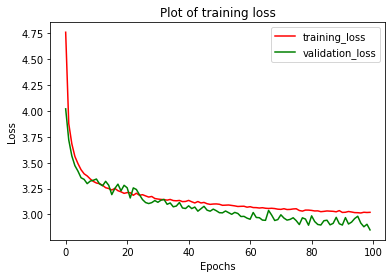

In [38]:
plot_loss(train_loss, epochs, val_loss)

### Load best model

In [39]:
load_checkpoint(torch.load("my_checkpoint.pth.tar"), model_cpp, optimizer_cpp)

=> Loading checkpoint


In [40]:
def test(max_len=300):
    model_cpp.eval()
    test_py_dir = '../input/d/palash97/translate-code/Dataset/Test/python'    
    txt_files = os.listdir(test_py_dir)
    soft = nn.Softmax(dim=2)
    
    for idx, txt_file in enumerate(txt_files):
        test_py_file = os.path.join(test_py_dir, txt_file)
        with open (test_py_file, 'r') as f:
            test_py = f.read()
        
        test_py_encoded = vocab.encode(test_py)
        
        # convert to tensor
        py_tensor = torch.LongTensor(test_py_encoded).unsqueeze(0).to(device)  # shape: (1, len_of_test_py_encoded)
        
        outputs = [vocab.stoi['<SOS>']]
        
        for i in range(max_len):
            cpp_tensor = torch.LongTensor(outputs).unsqueeze(0).to(device)  # shape: (1, len_of_outputs)
            
            with torch.no_grad():
                output = model_cpp(py_tensor, cpp_tensor)
            
            output = soft(output)
            pred = output.argmax(2)[:, -1].item()
            outputs.append(pred)
            
            if pred == vocab.stoi["<EOS>"]:
                break
        
        test_cpp_predicted = get_code(vocab=vocab,tokens=outputs)
        
        with open (f'cpp_{txt_file}', 'w') as f:
            f.write(test_cpp_predicted)
            f.close()

        print(f'\n\nTest case {idx+1}: ')
        print('\n*** Source code ***')
        print(test_py)
        print('\n*** Target code ***')
        print(test_cpp_predicted)

In [41]:
test()



Test case 1: 

*** Source code ***
def sub ( a : int , b : int ) -> int :
    c = a - b
    return z

*** Target code ***
int sub ( int a , int b ) { 
 int c = a - b ; 
return c 
}


Test case 2: 

*** Source code ***
def func1 ( a : float , b : float ) -> float :
    c = a + b
    return c

*** Target code ***
float func1 ( float a , float b ) { 
int c = a + b ; 
return c ; 
}


Test case 3: 

*** Source code ***
def func ( p : int , q : int ) -> int :
    r = p / q
    return r

*** Target code ***
int func ( int p , int q ) { 
int r = p / q ; 
return r ; 
}


Test case 4: 

*** Source code ***
def func1 ( p : int , q : int ) -> int :
    r = p / q
    return r

*** Target code ***
int func1 ( int p , int q ) { 
int r = p / q ; 
return r ; 
}


Test case 5: 

*** Source code ***
def func2 ( x : int , y : int , z : int ) -> int :
    ans = x + y - z
    return ans

*** Target code ***
int func2 ( int x , int y , int z ) { 
int ans = x + y ; 
return ans ; 
}


Test case 6: 

*** Sour